# Computer Vision - Data Preparation
*Eleonora Pedrini-Pedroli, Leo Rettich*

The following notebook downloads all the image data from https://github.com/toelt-llc/HSLU-Computer-Vision-Lab-Student-Version/archive/refs/heads/main.zip, transforms the data to numpy arrays that are ready to be applied in a deep learning model. The prepared data is stored as a pickle file to google drive. 

In [ ]:
import numpy as np
import pandas as pd
import zipfile
import os
import pickle

from google.colab import drive

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

Download the data as one zip file to the colab's file system:

In [ ]:
!wget --no-check-certificate "https://github.com/toelt-llc/HSLU-Computer-Vision-Lab-Student-Version/archive/refs/heads/main.zip" -O "/tmp/data.zip"

--2023-03-25 20:12:32--  https://github.com/toelt-llc/HSLU-Computer-Vision-Lab-Student-Version/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/toelt-llc/HSLU-Computer-Vision-Lab-Student-Version/zip/refs/heads/main [following]
--2023-03-25 20:12:32--  https://codeload.github.com/toelt-llc/HSLU-Computer-Vision-Lab-Student-Version/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.114.9
Connecting to codeload.github.com (codeload.github.com)|140.82.114.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/data.zip’

/tmp/data.zip           [<=>                 ] 991.56M  17.6MB/s    in 78s     

2023-03-25 20:13:52 (12.8 MB/s) - ‘/tmp/data.zip’ saved [1039730643]



Extract the zip file in the file system:

In [ ]:
zip_ref = zipfile.ZipFile('/tmp/data.zip', 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
base_dir = "/tmp/HSLU-Computer-Vision-Lab-Student-Version-main/data/Kather_texture_2016_image_tiles_5000"

Read the image data:

In [ ]:
# Function reads in all the images in the folders and derives the label from the folder name. 
# base_dir: parent folder, where all the labelled folders are inside. 
# exclude_keys: Files containing a key from the exclude_keys parameter are excluded.
def read_images(base_dir, exclude_keys=[]):
  data = []
  labels = []
  large_image_refs = []
  for folder in os.listdir(base_dir):
    if not folder.startswith("."):
      for file in os.listdir(os.path.join(base_dir, folder)):
        if not any([exclude in file for exclude in exclude_keys]):
          # Load image to python object
          img = load_img(os.path.join(base_dir, folder, file))
          # transform to numpy array
          img = img_to_array(img)
          # Normalize the pixel data to be between 0 and 1 (instead of 0 and 255)
          img /= 255
          data.append(img)
          labels.append(folder)
          # derive the origin large image from the file name
          large_image_refs.append(file.split("_")[1][:14])
  data = np.array(data, dtype="float32")
  labels = np.array(labels)
  large_image_refs = np.array(large_image_refs)
  # Shuffle the data
  idxs = np.arange(data.shape[0])
  np.random.seed(1)
  np.random.shuffle(idxs)
  return data[idxs], labels[idxs], large_image_refs[idxs]

Read in all the data

In [ ]:
data, labels, large_image_refs = read_images(base_dir)
print(data.shape)
print(labels.shape)
print(large_image_refs.shape)

(5000, 150, 150, 3)
(5000,)
(5000,)


In [ ]:
df = pd.DataFrame({'label': labels, 'larg_img_ref': large_image_refs})

Show the distribution of _ for the different large images:

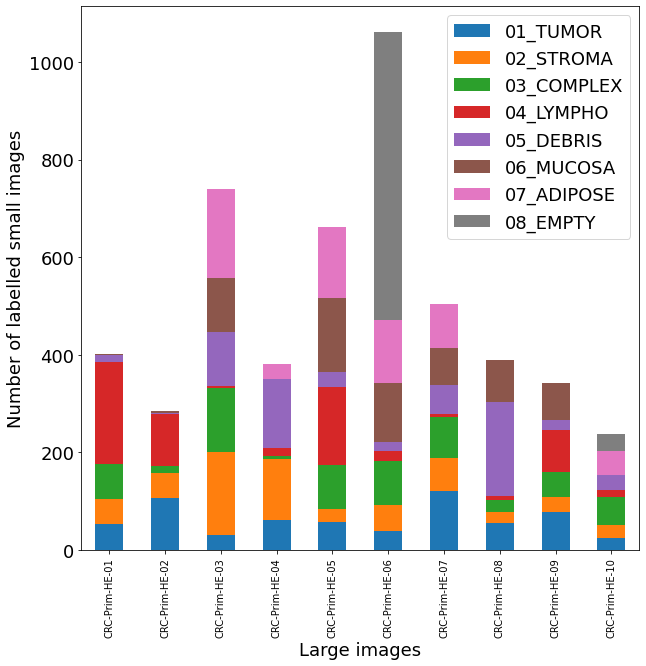

In [ ]:
ax = pd.crosstab(df['larg_img_ref'],df['label']).plot(kind='bar', stacked=True, figsize=(10, 10))
ax.legend(fontsize=18)
ax.set_xlabel("Large images", fontsize=18)
ax.set_ylabel("Number of labelled small images", fontsize=18)
ax.tick_params(axis='y', labelsize=18)

In [ ]:

df.groupby(['label']).count()

,larg_img_ref
label,
01_TUMOR,625
02_STROMA,625
03_COMPLEX,625
04_LYMPHO,625
05_DEBRIS,625
06_MUCOSA,625
07_ADIPOSE,625
08_EMPTY,625


In the end, our model should be applied to the larger images. In order to still have a large image that is completely new to the model, all data from one image is excluded. To still end up with a balanced dataset, we choose image 10, as it is rather balanced itself. 

In [ ]:
data, labels, large_image_refs = read_images(base_dir, exclude_keys=["Prim-HE-10"])
print(data.shape)
print(labels.shape)
print(large_image_refs.shape)

(4762, 150, 150, 3)
(4762,)
(4762,)


In [ ]:
df = pd.DataFrame({'label': labels, 'larg_img_ref': large_image_refs})
df.groupby(['label']).count()

,larg_img_ref
label,
01_TUMOR,600
02_STROMA,598
03_COMPLEX,568
04_LYMPHO,612
05_DEBRIS,594
06_MUCOSA,625
07_ADIPOSE,575
08_EMPTY,590


Store the final dataset to google drive:

In [ ]:
dataset = {'data': data, 'labels': labels}

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
with open('gdrive/MyDrive/Computer_Vision/dataset.pickle', 'wb') as f:
    pickle.dump(dataset, f)